In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_4hcopy_ratioFR_cov_mat_final.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=300000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
#check if the covariance matrix is positive definite
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

5.600208498896647e-09


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             tau_2cbo = 0.0,
             omega_2cbo = 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [7]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.34062e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.39311e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.40369e-02,
        -1.99555e+01,
        1.10668e-04,
        1.70775e+05,
        4.69116e-03,
        3.06805e+00]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [12]:
for ipar in range(0,23):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22886057744000568        +-   8.907195566291473e-06   

-44.566262550615214        +-   0.4965813385705371   

4.014167897874966        +-   7.548437129368285e-05   

0.0023016873225659706        +-   2.531790313075554e-05   

252580.15941498702        +-   8474.472918607558   

0.0023403963710366136        +-   1.329331030547593e-07   

-0.6142068946173502        +-   0.01101237504794419   

0.0008307108134572031        +-   7.619433833057133e-05   

-6.944325272580954        +-   0.09101297559791059   

-8.571190415256619e-05        +-   7.620766567214955e-05   

34.01767409337391        +-   0.9042194968151468   

0.00019691646523291458        +-   3.146046252092905e-05   

176129.15082291275        +-   57387.047840888226   

0.013929630923416892        +-   1.8533842781869898e-06   

-0.38964477673072534        +-   0.16027656034791468   

0.0014565094773346795        +-   0.00021934524649234072   

27834.97798123553        +-   2638.4023400088868   

0.014037420796723299       

In [13]:
pars_final

array([ 2.28860577e-01, -4.45662626e+01,  4.01416790e+00,  2.30168732e-03,
        2.52580159e+05,  2.34039637e-03, -6.14206895e-01,  8.30710813e-04,
       -6.94432527e+00, -8.57119042e-05,  3.40176741e+01,  1.96916465e-04,
        1.76129151e+05,  1.39296309e-02, -3.89644777e-01,  1.45650948e-03,
        2.78349780e+04,  1.40374208e-02, -2.08515753e+01,  1.22104884e-04,
        1.36921771e+05,  4.68870046e-03,  3.06062562e+00])

In [14]:
stdevs

array([8.90719557e-06, 4.96581339e-01, 7.54843713e-05, 2.53179031e-05,
       8.47447292e+03, 1.32933103e-07, 1.10123750e-02, 7.61943383e-05,
       9.10129756e-02, 7.62076657e-05, 9.04219497e-01, 3.14604625e-05,
       5.73870478e+04, 1.85338428e-06, 1.60276560e-01, 2.19345246e-04,
       2.63840234e+03, 3.40739897e-06, 1.50917725e-01, 3.25831581e-05,
       7.11378071e+04, 3.78656440e-06, 2.65826096e-01])

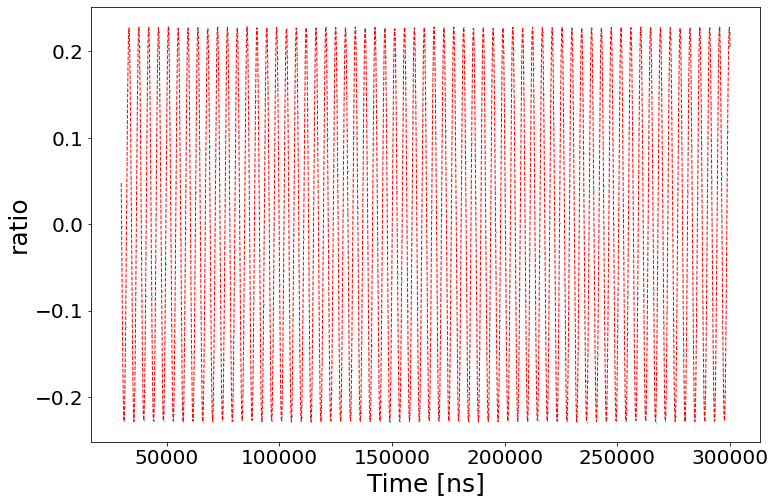

In [15]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [16]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

Text(0, 0.5, 'data-fit/sigma')

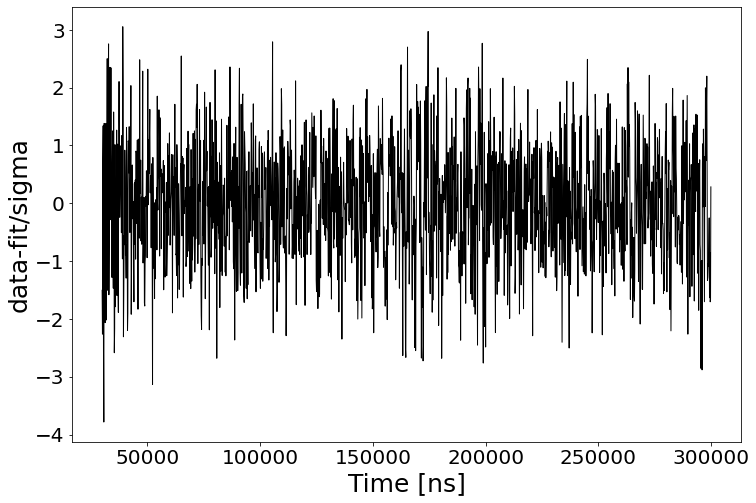

In [17]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
#plt.savefig('run2all_res.jpg')

In [18]:
fou=abs(np.fft.fft(res))

In [19]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.963111111111111

Text(0, 0.5, 'FFT Mag [arb. units]')

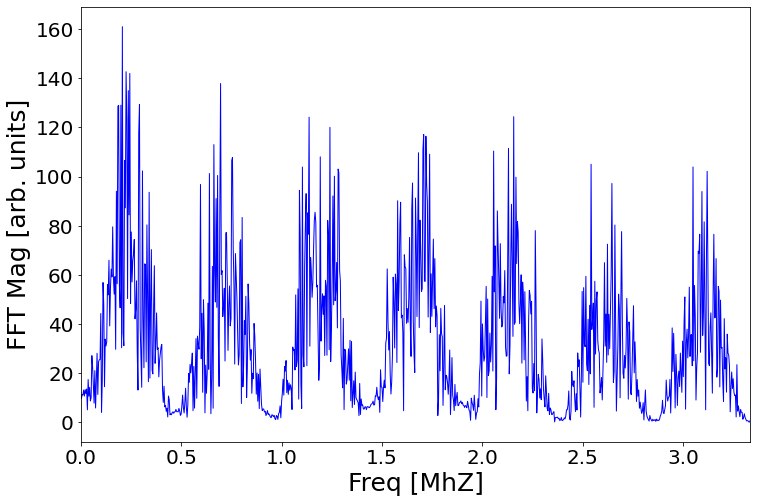

In [20]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
#plt.savefig('run2all_fft.jpg')

In [21]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [22]:
chi2

1719.7746442828404

In [23]:
ndf=fit_range-len(pars_final)

In [24]:
red_chi2=chi2/ndf

In [25]:
red_chi2

0.9672523308677393

In [26]:
auto_corr=abs(np.fft.fft(fou*fou))

In [27]:
x_auto_corr= np.linspace(0,fit_range,num=fit_range)
x_auto_corr[800]

800.4444444444446

Text(0, 0.5, 'FFT Mag [arb. units]')

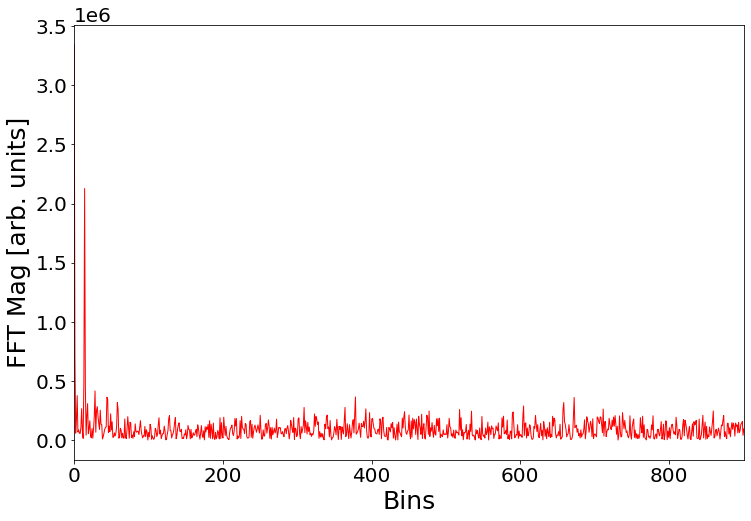

In [28]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_auto_corr, auto_corr, linestyle='solid', linewidth=1, color='red')
plt.xlim([0,fit_range/2])
plt.xlabel('Bins',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)

In [29]:
auto_corr[0]

3343510.1468539573

In [37]:
auto_corr[14]/auto_corr[0]

0.6361943975865227

In [38]:
auto_corr[28]/auto_corr[0]

0.12430357255692089

In [39]:
auto_corr[1]/auto_corr[0]

0.2093771421971871

In [40]:
auto_corr[13]/auto_corr[0]

0.14386599458241653

In [41]:
auto_corr[15]/auto_corr[0]

0.13527882870484811